In [124]:
import transformers
from transformers import ByT5Tokenizer, T5ForConditionalGeneration, T5Config
import torch
import seaborn as sns
from tqdm import tqdm
import numpy as np
import math
import gc
from pynvml import *
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

nvmlInit()


from src.myt5_tokenizer import MyT5Tokenizer

In [136]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Ubuntu Serif']
mpl.rcParams['mathtext.fontset'] = 'cm'
# bigger size
mpl.rcParams['font.size'] = 14

In [137]:
def print_gpu_mem_usage():
    h = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(h)
    print(f'total    : {info.total}')
    print(f'free     : {info.free}')
    print(f'used     : {info.used}')

## Sentence Sample

In [151]:
sentences = ["የአውሮፕላን አብራሪው የአየር ሀይል መሪ ዲሎክሪት ፓታቪ ሆኖ ተለይቷል።",
             "The pilot was identified as Squadron Leader Dilokrit Pattavee.",
             "Der Pilot wurde als Staffelführer Dilokrit Pattavee identifiziert.",
             "Išsiaiškinta, kad pilotas – eskadrilės vadas Dilokritas Pattavee.",
             "涉事飞行员是空军中队长迪罗里·帕塔维 (Dilokrit Pattavee)。",
             "Pilota zidentyfikowano jako Dilokrita Pattavee, dowódcę eskadry."]

sentences_2 =  ['We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.',
                "አሁን የስኳር በሽተኛ ያልነበሩ አሁን ግን የሆኑ የ4-ወር-ዕድሜ ያላቸው አይጦች አሉን፣ አለ። ",
                "„Mamy teraz myszy w wieku 4 miesięcy, które miały cukrzycę, ale zostały z niej wyleczone” – dodał.",
                "「我們有 4 個月大曾經罹患糖尿病老鼠現在沒有糖尿病了」他補充道。"]

prefixes = [sent[:5] for sent in sentences]
sufixes = [sent[5:] for sent in sentences]

## Load Byte and Morpholofical Models

In [152]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [153]:
byt5_small = T5ForConditionalGeneration.from_pretrained("../hf_checkpoints/byt5_small_250000" ,use_safetensors=True).to(device)
by_tokenizer = ByT5Tokenizer()

In [154]:
myt5_small = T5ForConditionalGeneration.from_pretrained("../hf_checkpoints/myt5_small_250000" ,use_safetensors=True).to(device)
my_tokenizer = MyT5Tokenizer(decompose_map="byte_maps/decompose_map.json",
                               merge_map="byte_maps/merge_map.json")


# TODOs
- check how loss is computed
- run on Flores
- compare multiple models

## Evaluate NLL on sentence levels

In [155]:
def evaluate_texts(text_dataset, model, tokenizer, batch_size=32, context=0):
    
    sentence_nlls = []
    sentence_bpbs = []
    sentence_compressions = []
    context = min(abs(context), 1.0)

    for i in tqdm(range(0, len(text_dataset), batch_size)):
        batch = text_dataset[i:i+batch_size]
        batch_contexts = [math.floor(context * len(sent.split(" "))) for sent in batch]

        batch_prefixes = [" ".join(sent.split(" ")[:bc]) + " " for sent, bc in zip(batch,batch_contexts) ]
        batch_suffixes = ["" + " ".join(sent.split(" ")[bc:]) for sent, bc in zip(batch,batch_contexts) ]
        byte_lengths = torch.tensor([len(suf.encode("utf-8")) +1 for suf in batch_suffixes]).to(device)
        if len(batch_prefixes) == 0:
            continue

        inputs = tokenizer(
            batch_prefixes, padding="longest", return_tensors="pt"
        ).to(device)
        targets = tokenizer(
            batch_suffixes, padding="longest", return_tensors="pt"
        ).to(device)

        

        outputs = model(**inputs, labels=targets.input_ids)
        
        logits = outputs.logits
        logits = torch.nn.functional.log_softmax(logits, dim=-1)

        target_labels = targets.input_ids.unsqueeze(-1)
        mask = targets.attention_mask

        target_logits = torch.gather(logits, -1, target_labels).squeeze(-1)

        batch_nlls = -torch.sum(mask * target_logits, axis=-1)
        batch_bpbs = torch.exp(-torch.sum(mask * target_logits , axis=-1)/byte_lengths)
        batch_compressions = torch.sum(mask, axis=-1) / byte_lengths
        #print(outputs.loss * batch_compressions)
        sentence_nlls.extend(batch_nlls.tolist())
        sentence_bpbs.extend(batch_bpbs.tolist())
        sentence_compressions.extend(batch_compressions.tolist())

        del batch_nlls
        del batch_bpbs
        del byte_lengths
        del batch_compressions
        del targets
        del logits
        del mask
        del target_logits
        del inputs
        
    gc.collect()
    torch.cuda.empty_cache()
    return sentence_nlls, sentence_bpbs, sentence_compressions

In [156]:
sentences = ["የአውሮፕላን አብራሪው የአየር ሀይል መሪ ዲሎክሪት ፓታቪ ሆኖ ተለይቷል።",
             "The pilot was identified as Squadron Leader Dilokrit Pattavee.",
             "Der Pilot wurde als Staffelführer Dilokrit Pattavee identifiziert.",
             "Išsiaiškinta, kad pilotas – eskadrilės vadas Dilokritas Pattavee.",
             "涉事飞行员是空军中队长迪罗里·帕塔维 (Dilokrit Pattavee)。",
             "Pilota zidentyfikowano jako Dilokrita Pattavee, dowódcę eskadry."]

In [157]:
sentences[0]

'የአውሮፕላን አብራሪው የአየር ሀይል መሪ ዲሎክሪት ፓታቪ ሆኖ ተለይቷል።'

In [158]:
evaluate_texts(sentences, myt5_small, my_tokenizer, context=0.0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


([344.41912841796875,
  184.39285278320312,
  221.56158447265625,
  261.39288330078125,
  317.94610595703125,
  246.89828491210938],
 [17.639829635620117,
  18.66911506652832,
  26.004213333129883,
  39.709476470947266,
  62.12636184692383,
  39.847076416015625],
 [0.6499999761581421,
  0.8571428656578064,
  0.8529411554336548,
  0.8873239159584045,
  1.0129870176315308,
  0.8507462739944458])

In [159]:
evaluate_texts(sentences, byt5_small, by_tokenizer, context=0.75)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]


([99.24930572509766,
  97.23030090332031,
  60.187068939208984,
  96.29308319091797,
  60.331050872802734,
  79.76341247558594],
 [15.751335144042969,
  42.0822868347168,
  12.277823448181152,
  98.04090881347656,
  103.63240814208984,
  66.55803680419922],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

## Load Flores Dataset for some language

In [13]:
# load flores dataset for languages: en, es, pt, fr, it, ro, pl, mt, ja, zh, ko, te, ta

# language sample
languages = ['en', 'de', 'fr', 'ru','pl','ja', 'vi', 'ko','hy', 'kk', 'el', 'ta','te','am', 'sn', 'mt', 'sm', 'st']

palette = sns.color_palette("viridis", len(languages))
languages_colors = {lang: col for lang, col in zip(languages, palette)}
nice_colors = [ ]



# use the code from above to get the flores200 languages
# Latin / Corsican / Hawaiian language not in Flores
languages_flores = {'en': 'eng_Latn', 'ceb': 'ceb_Latn', 'de': 'deu_Latn', 'sv': 'swe_Latn', 'fr': 'fra_Latn', 'nl': 'nld_Latn', 'ru': 'rus_Cyrl', 'es': 'spa_Latn',
                    'it': 'ita_Latn', 'pl': 'pol_Latn', 'ja': 'jpn_Jpan', 'zh': 'zho_Hans', 'uk': 'ukr_Cyrl', 'vi': 'vie_Latn', 'ar': 'arb_Arab',
                    'pt': 'por_Latn', 'fa': 'pes_Arab', 'ca': 'cat_Latn', 'sr': 'srp_Cyrl', 'id': 'ind_Latn', 'ko': 'kor_Hang', 'no': 'nob_Latn',
                    'fi': 'fin_Latn', 'tr': 'tur_Latn', 'cs': 'ces_Latn', 'hu': 'hun_Latn', 'ro': 'ron_Latn', 'eu': 'eus_Latn', 'ms': 'zsm_Latn',
                    'eo': 'epo_Latn', 'he': 'heb_Hebr', 'hy': 'hye_Armn', 'da': 'dan_Latn', 'bg': 'bul_Cyrl', 'cy': 'cym_Latn', 'sk': 'slk_Latn',
                    'uz': 'uzn_Latn', 'et': 'est_Latn', 'be': 'bel_Cyrl', 'kk': 'kaz_Cyrl', 'el': 'ell_Grek', 'lt': 'lit_Latn', 'gl': 'glg_Latn',
                    'ur': 'urd_Arab', 'az': 'azj_Latn', 'sl': 'slv_Latn', 'ka': 'kat_Geor', 'hi': 'hin_Deva', 'th': 'tha_Thai', 'ta': 'tam_Taml',
                    'bn': 'ben_Beng', 'mk': 'mkd_Cyrl',  'lv': 'lvs_Latn', 'af': 'afr_Latn', 'tg': 'tgk_Cyrl', 'my': 'mya_Mymr',
                    'mg': 'plt_Latn', 'sq': 'als_Latn', 'mr': 'mar_Deva', 'te': 'tel_Telu', 'ml': 'mal_Mlym', 'ky': 'kir_Cyrl', 'sw': 'swh_Latn',
                    'jv': 'jav_Latn', 'ht': 'hat_Latn', 'lb': 'ltz_Latn', 'su': 'sun_Latn', 'ku': 'kmr_Latn', 'ga': 'gle_Latn', 'is': 'isl_Latn',
                    'fy': 'fao_Latn', 'pa': 'pan_Guru', 'yo': 'yor_Latn', 'ne': 'npi_Deva', 'ha': 'hau_Latn', 'kn': 'kan_Knda', 'gu': 'guj_Gujr',
                    'mn': 'khk_Cyrl', 'ig': 'ibo_Latn', 'si': 'sin_Sinh', 'ps': 'pbt_Arab', 'gd': 'gla_Latn', 'sd': 'snd_Arab', 'yi': 'ydd_Hebr',
                    'am': 'amh_Ethi', 'sn': 'sna_Latn', 'zu': 'zul_Latn', 'km': 'khm_Khmr', 'so': 'som_Latn', 'mi': 'mri_Latn',
                    'mt': 'mlt_Latn', 'lo': 'lao_Laoo', 'xh': 'xho_Latn', 'sm': 'smo_Latn', 'ny': 'nya_Latn', 'st': 'sot_Latn'}

flores = {}

for lang in languages:
    with open(f'flores200_dataset/devtest/{languages_flores[lang]}.devtest', 'r') as f:
        flores[lang] = f.read().splitlines()

## Compute results

In [14]:
bpbs = {"my_small": {}, "by_small": {}, "mixed_small": {}}
nlls = {"my_small": {}, "by_small": {}, "mixed_small": {}}
comps = {"my_small": {}, "by_small": {}, "mixed_small": {}}

In [15]:
bpbs_75 = {"my_small": {}, "by_small": {}, "mixed_small": {}}
nlls_75 = {"my_small": {}, "by_small": {}, "mixed_small": {}}
comps_75 = {"my_small": {}, "by_small": {}, "mixed_small": {}}

In [17]:
for lang in languages:
    print(f"Evaluating: {lang}")
    nlls_75["my_small"][lang], bpbs_75["my_small"][lang], comps_75["my_small"][lang] = evaluate_texts(flores[lang], myt5_small, my_tokenizer, batch_size=8, context=0.75)
    nlls_75["my_small"][lang], bpbs_75["by_small"][lang], nlls_75["by_small"][lang], comps_75["by_small"][lang] = evaluate_texts(flores[lang], byt5_small, by_tokenizer, batch_size=4, context=0.75)

    nlls["my_small"][lang],bpbs["my_small"][lang], comps["my_small"][lang] = evaluate_texts(flores[lang], myt5_small, my_tokenizer, batch_size=8, context=0.0)
    nlls["by_small"][lang],bpbs["by_small"][lang], comps["by_small"][lang] = evaluate_texts(flores[lang], byt5_small, by_tokenizer, batch_size=4, context=0.0)
    print_gpu_mem_usage()

Evaluating: en


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 39.36it/s]


total    : 25769803776
free     : 21587427328
used     : 4182376448
Evaluating: de


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:07<00:00, 35.70it/s]


total    : 25769803776
free     : 21530804224
used     : 4238999552
Evaluating: fr


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:07<00:00, 34.28it/s]


total    : 25769803776
free     : 21648244736
used     : 4121559040
Evaluating: ru


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 25.92it/s]


total    : 25769803776
free     : 21308506112
used     : 4461297664
Evaluating: pl


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 36.40it/s]


total    : 25769803776
free     : 21629370368
used     : 4140433408
Evaluating: ja


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:07<00:00, 34.46it/s]


total    : 25769803776
free     : 21631467520
used     : 4138336256
Evaluating: vi


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:07<00:00, 32.42it/s]


total    : 25769803776
free     : 21264465920
used     : 4505337856
Evaluating: ko


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:07<00:00, 35.26it/s]


total    : 25769803776
free     : 21534998528
used     : 4234805248
Evaluating: hy


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:10<00:00, 25.05it/s]


total    : 25769803776
free     : 20970864640
used     : 4798939136
Evaluating: kk


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 26.55it/s]


total    : 25769803776
free     : 21375614976
used     : 4394188800
Evaluating: el


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:10<00:00, 24.16it/s]


total    : 25769803776
free     : 21222522880
used     : 4547280896
Evaluating: ta


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:14<00:00, 17.95it/s]


total    : 25769803776
free     : 19951648768
used     : 5818155008
Evaluating: te


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:12<00:00, 20.78it/s]


total    : 25769803776
free     : 20866007040
used     : 4903796736
Evaluating: am


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:12<00:00, 20.87it/s]


total    : 25769803776
free     : 21222522880
used     : 4547280896
Evaluating: sn


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 38.59it/s]


total    : 25769803776
free     : 21610496000
used     : 4159307776
Evaluating: mt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 37.59it/s]


total    : 25769803776
free     : 21306408960
used     : 4463394816
Evaluating: sm


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 37.25it/s]


total    : 25769803776
free     : 21568552960
used     : 4201250816
Evaluating: st


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:06<00:00, 36.48it/s]


total    : 25769803776
free     : 21446918144
used     : 4322885632


In [18]:
print_gpu_mem_usage()

total    : 25769803776
free     : 21446918144
used     : 4322885632


In [161]:
from copy import copy

## Analysis of the results

In [168]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [169]:
def plot_paired_boxplot(nested_dict, y_label="NLL", title=None, y_logscale=True):

    plt.figure(figsize=(12, 6))
    model_name_dict = {"by_small": "byT5 small", "my_small": "myT5 small"}
    data = []
    for model, model_vals in nested_dict.items():
        for lang, lang_vals in model_vals.items():
            if lang == 'ja':
                continue
            for val in lang_vals:
                data.append([lang, model_name_dict[model], val])
    df = pd.DataFrame(data, columns=['Language', 'Model', y_label])
    flierprops = dict(marker='o', markersize=5, markerfacecolor='grey', alpha=0.1)
    sns.boxplot(x='Language', y=y_label, hue='Model', data=df,flierprops= flierprops)

    if y_logscale:
        plt.yscale('log')
    else:
        plt.ylim(0,100)

    if title:
        plt.savefig(f"{title}.png", dpi=300)
    plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not 

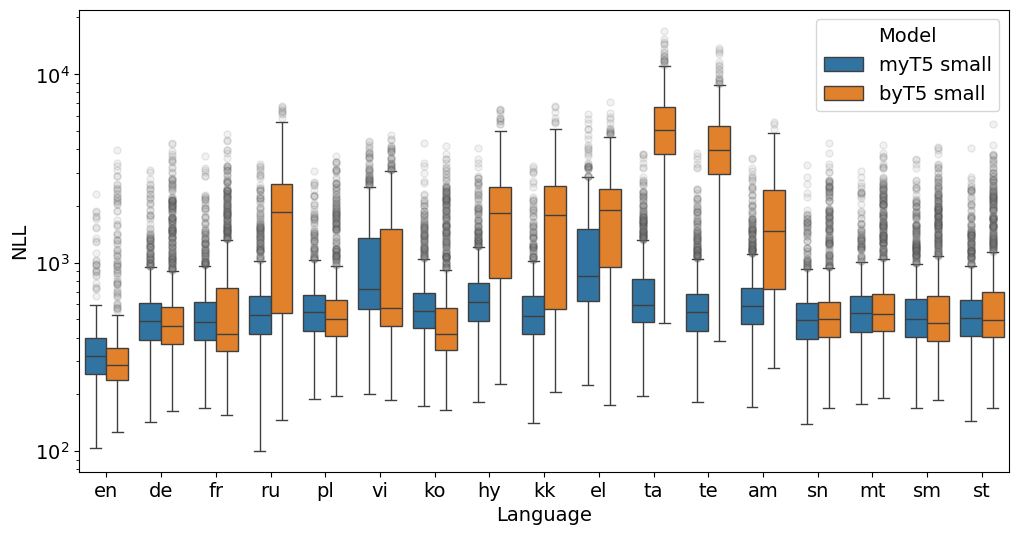

In [175]:
plot_paired_boxplot(nlls, title="nll_no_context")

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not 

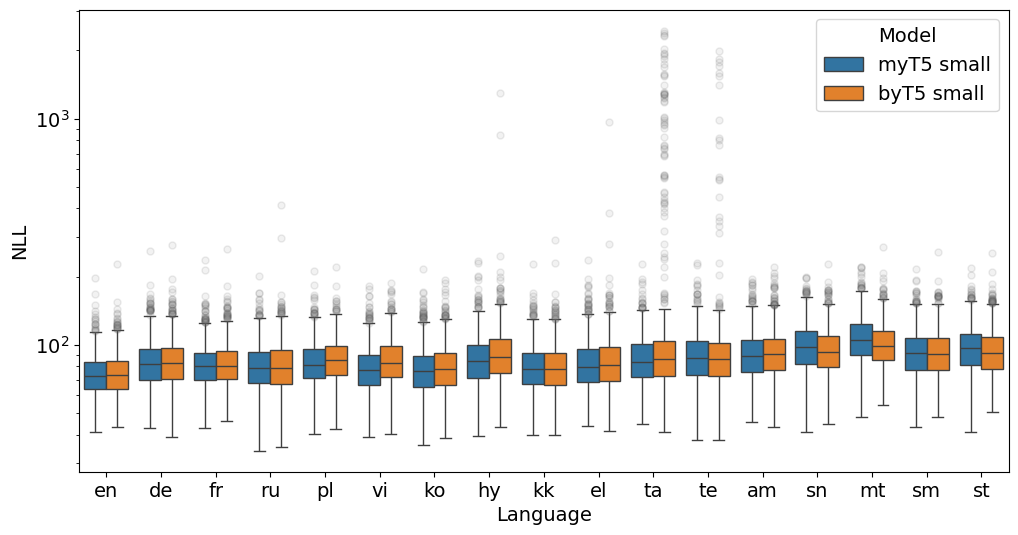

In [179]:
plot_paired_boxplot(nlls_75, title="nll_0.75_context")

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not 

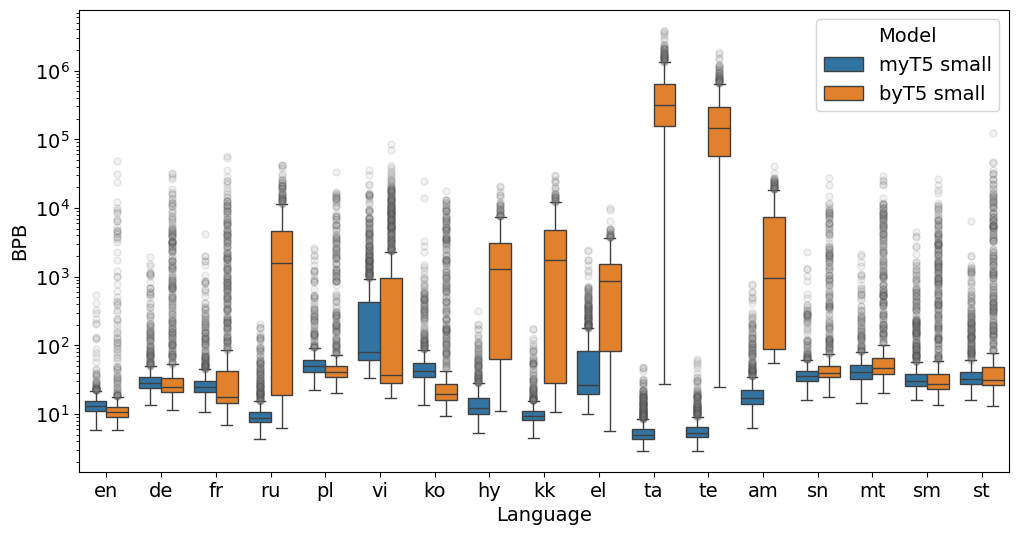

In [177]:
plot_paired_boxplot(bpbs,title="bpb_no_context", y_label="BPB", y_logscale=True)

findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu Serif
findfont: Generic family 'serif' not 

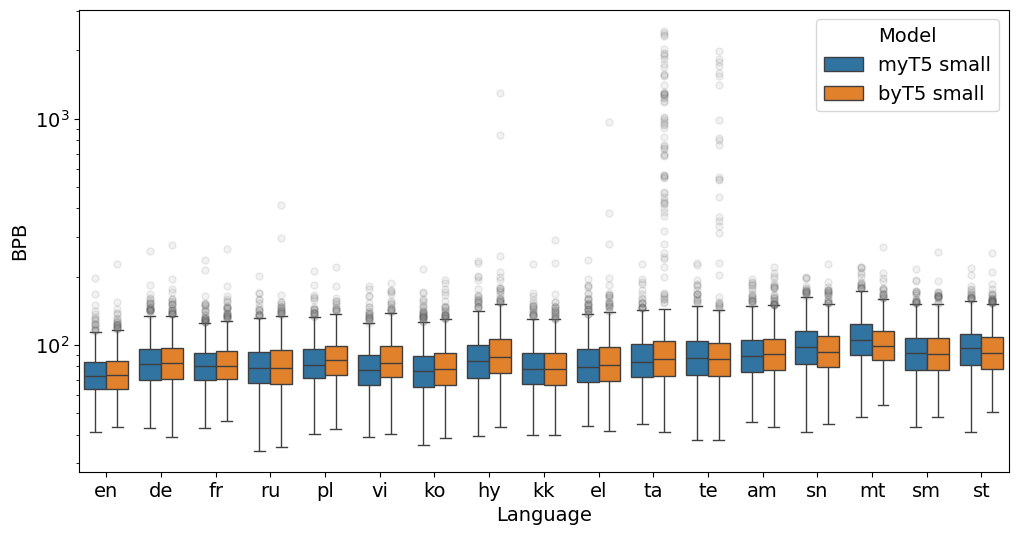

In [147]:
plot_paired_boxplot(bpbs_75, y_label="BPB", y_logscale=True)

In [103]:
nlls_75_data = []
for model, model_vals in nlls_75.items():
    for lang, lang_vals in model_vals.items():
        for val in lang_vals:
            nlls_75_data.append([lang, model, val])
nlls_75_df = pd.DataFrame(nlls_75_data, columns=['Language', 'Model', 'NLL'])

In [ ]:
bpbs_data = []
for model, model_vals in nlls.items():
    for lang, lang_vals in model_vals.items():
        for val in lang_vals:
            nlls_data.append([lang, model, val])
nlls_df = pd.DataFrame(nlls_data, columns=['Language', 'Model', 'NLL'])